# Jigsaw puzzle solving via SMC with Permutations

Project by : Philippe Peroumal, Guillaume Demonet

Reference : [Sequential Monte Carlo for Maximum Weight Subgraphs with Application to Solving Image Jigsaw Puzzles](https://cis.temple.edu/~latecki/Papers/IJCV2014.pdf)

### Table of Contents

This notebook is further divided into 6 parts :

0. [Project _init_](#Project-init)
1. [Image manipulation](#Image-manipulation)
2. [Dissimilarity and affinity](#Dissimilarity-and-affinity)
3. [Particles and the SMC algorithm](#Particles-and-the-SMC-algorithm)
4. [How to use](#How-to-use)
5. [Results](#Results)

## Project _init_

If you run this project from the GitHub [repo](https://github.com/NaasCraft/SMC_2017), this notebook should reside under `path/to/repo/code/`, and images should be stored under `path/to/repo/img/`.

Please adapt the following `.._PATH` variables according to your local setup.

In [181]:
# imports
import os
from os import path as osp
import pickle

import numpy as np
from scipy import ndimage
from skimage import color

%matplotlib inline
import matplotlib.pyplot as plt

In [182]:
# globals
BASE_PATH = osp.abspath('../')
IMG_PATH = osp.join(BASE_PATH, 'img')

## Image manipulation

(-0.5, 671.5, 503.5, -0.5)

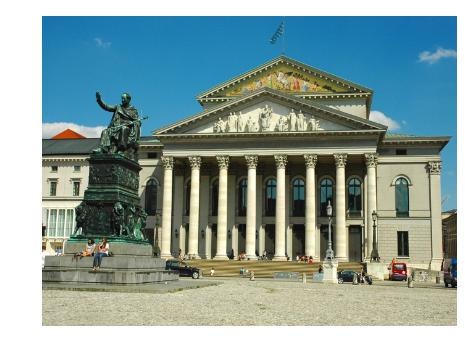

In [183]:
# acquire an image to make some tests

def img_path(img_id):
    return osp.join(IMG_PATH, '{}.png'.format(img_id))

sample = ndimage.imread(img_path(6))
plt.imshow(sample)
plt.axis('off')

All images (stored in `path/to/repo/img/`) are of shape **504x672**. We can thus split them into **9x12** grids of equal squares of size **56**. The following shows the grid :

(0.0, 672.0, 504.0, 0.0)

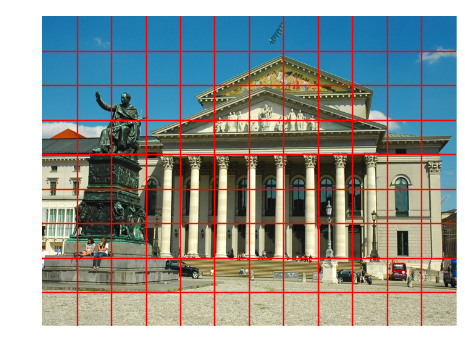

In [184]:
plt.imshow(sample)

for i in range(1,12):
    plt.plot([56*i,56*i],[0,504], 'r-')
for i in range(1,9):
    plt.plot([0,672], [56*i,56*i], 'r-')
    
plt.axis([0,672,504,0])
plt.axis('off')

To manipulate pieces of the jigsaw puzzle, we need to store them as separate images. The split is defined below :

In [185]:
# define a splitter function
def split_img(img, size=56):
    pieces = []
    vshape = img.shape[0]
    hshape = img.shape[1]
    
    if vshape%size != 0 or hshape%size != 0:
        raise 'Problem with image shape and patch size'
    
    for hb in range(0,hshape,size):
        #b for begin, e for end
        he = hb + size
        for vb in range(0,vshape,size):
            ve = vb + size
            pieces.append(img[vb:ve, hb:he, :])
            
    return pieces

In [186]:
pieces = split_img(sample)
len(pieces)

108

So the puzzle is correctly made out of 108 (9x12) pieces, as in the aforementioned article. However, the images are still ordered :

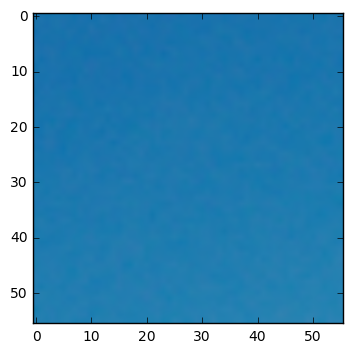

In [187]:
plt.imshow(pieces[0]) # should be top left corner, hence blue sky

We also define a function to assemble pieces, given in the same order as they come out from `split_img`.

This way, `assemble_pieces(split_img(img))` = `img`.

In [188]:
def assemble_pieces(pieces):
    full_pic = np.zeros((504, 672, 3), dtype=np.uint8)
    size = 56
    for i in range(len(pieces)):
        h_ix = (i//9) * size
        v_ix = (i%9) * size

        full_pic[v_ix:v_ix+size, h_ix:h_ix+size, :] = pieces[i]
    
    return full_pic

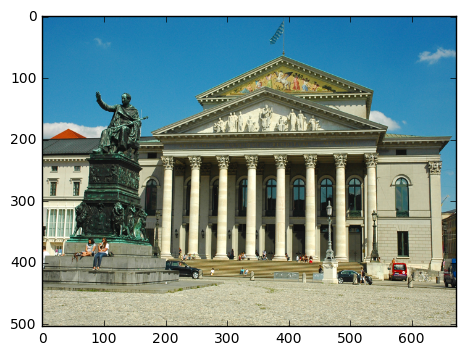

In [189]:
plt.imshow(assemble_pieces(pieces))

In the algorithm, we may want to shuffle the given pieces :

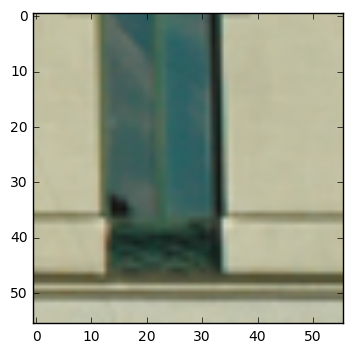

In [19]:
shuffled_pieces = pieces
np.random.shuffle(shuffled_pieces)
plt.imshow(shuffled_pieces[0]) #shouldn't be (probably) blue sky anymore

## Dissimilarity and affinity

### An excursion into a full A matrix

What's a graph in our context ?

+ A graph is a set $(V, E, a)$, where :
    
+ $V$ is a set of vertices, i.e. $v_j = (p_i, q_i)$ 
    + with $p_i$ being a patch index ($p_i = i \in \{0, ..., 108\}$)
    + and $q_i$ being a grid location index ($q_i = i \in \{0, ..., 108\}$)

+ $E$ is a set of edges (couples of $(v_i, v_j)$)

+ $a$ is the weight function

However, the article tells us the common usage is to represent the graph as an affinity matrix $A = (a_{ij})$ such that :

+ If $(v_i, v_j) \in E$ (that is, the two potential pairs are consistent with the graph rules), we have $a_{ij} = a(v_i, v_j)$
+ Else, $a_{ij} = 0$

In our case then, $A$ is of size $108^2$ x $108^2$, though is sparse : a simple rule "if $(p_i, q_j)$ in the selected vertices, then $\forall k$ in the remaining locations, $(p_i, q_k)$ cannot be selected" means that only one in 108 edges $a_{ij}$ may have a non-zero value.

In [13]:
size = 108**2
A = np.zeros((size,size))

In [ ]:
mem = A.nbytes
ngig = int(mem/(1024**3))
nmeg = mem/(1024**2) - ngig*1024
print("A is of size {}GB and {}MB".format(ngig, round(nmeg,2)))

Here we can see that $A$ takes up a lot of RAM (1GB), and making use of sparse implementation would be smart. However, we have sufficient memory available (>10GB), so we don't mind this aspect.

### Back to earth : dissimilarity

After specifying the rules to apply to fill in $A$, we realized only $D$ was necessary (it is also explicitly mentioned in the article, but we missed it first).

In our case of puzzle solving, one wants to evaluate the probability that pieces $p_i$ and $p_j$ are compatible on a specific direction (e.g. Left-Right). The authors use, as in the loopy-belief propagation algorithm from Cho et al., 2010, a dissimilarity measure along the pieces edge. It is defined, for pieces defined as $K \times K \times 3$ arrays, as : $$D(p_i, p_j, LR) = \sum_{k=1}^K \sum_{c=1}^3 (p_i(k, u, c) - p_j(k, v, c))^2$$

with $u$ designing the first column and $v$ the last one. $D$ across all directions is computed in the same fashion.

In [20]:
def dissimilarity(img1, img2, side):
    # we compute dissimilarity between
    # two puzzle pieces along the first one's `side`
    # side can be 't', 'b', 'l' or 'r'
    if side == 't':
        vec1, vec2 = img1[0, :], img2[-1, :]
    elif side == 'b':
        vec1, vec2 = img1[-1, :], img2[0, :]
    elif side == 'l':
        vec1, vec2 = img1[:, 0], img2[-1, :]
    elif side == 'r':
        vec1, vec2 = img1[:, -1], img2[:, 0]
    else:
        raise Exception('side can only be "t","b","r" or "l". "{}" was given.'.format(side))
    
    diffs = (vec1-vec2).astype(np.uint32) #was using uint8 for imgs, 
                            # but not large enough for squared vals
    return np.sum(np.square(diffs))

Now let's check some of its properties and validate its behavior.

In [26]:
# defining some helpers to check the dissimilarity function
pieces = split_img(sample)

def assemble(img1,img2,side):
    l = img1.shape[0]
    if side == 't':
        assembly = np.zeros((2*l,l,3), dtype=np.uint8)
        assembly[l:,:] = img1
        assembly[:l,:] = img2
    elif side == 'b':
        assembly = np.zeros((2*l,l,3), dtype=np.uint8)
        assembly[:l,:] = img1
        assembly[l:,:] = img2
    elif side == 'l':
        assembly = np.zeros((l,2*l,3), dtype=np.uint8)
        assembly[:,l:] = img1
        assembly[:,:l] = img2
    elif side == 'r':
        assembly = np.zeros((l,2*l,3), dtype=np.uint8)
        assembly[:,:l] = img1
        assembly[:,l:] = img2
        
    return assembly
    
def check_diss(i,j,w,c):
    wrong = dissimilarity(pieces[i], pieces[j], w)
    correct = dissimilarity(pieces[i], pieces[j], c)
    
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(assemble(pieces[i], pieces[j], w))
    plt.subplot(122)
    plt.imshow(assemble(pieces[i], pieces[j], c))
    plt.show()
    
    print('Wrong side : {}'.format(wrong))
    print('Correct side : {}'.format(correct))
    print('-------')
    print('Ratio w/c: {}'.format(wrong/correct))

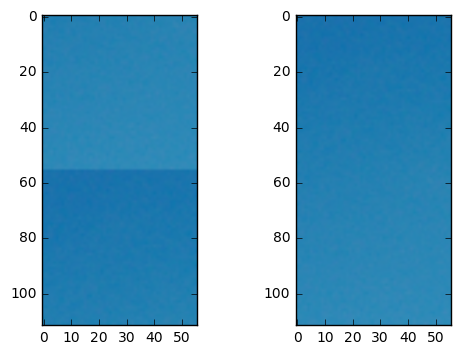

Wrong side : 9442904
Correct side : 3860648
-------
Ratio w/c: 2.4459375731742443


In [27]:
check_diss(0,1,'t','b')

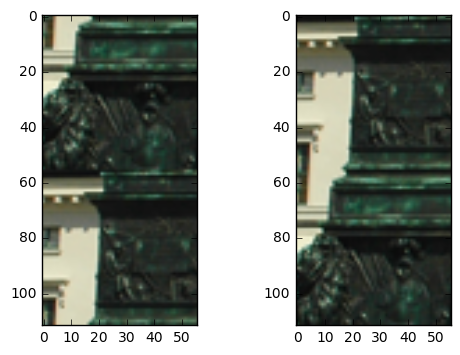

Wrong side : 6063916
Correct side : 1515713
-------
Ratio w/c: 4.000701979860303


In [28]:
check_diss(13,14,'t','b')

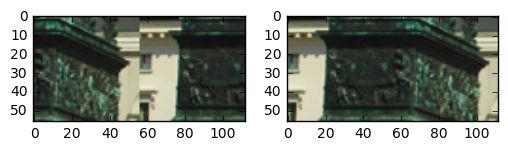

Wrong side : 3179941
Correct side : 5341172
-------
Ratio w/c: 0.5953639014059087


In [29]:
check_diss(13,22,'l','r')

The results feel correct though imperfect... Indeed, they are, since we missed another clue in the article : this dissimilarity measure works with **LAB** color space representation for the 3 channels, instead of **RGB**. To replicate as precisely as possible the article results, we even use the Matlab implementation of **NTSC** format (which is similar to **LAB**) that they used too.

In [148]:
NTSC_matrix = np.array([[0.299, 0.587, 0.114],
                        [0.596, -0.274, -0.322],
                        [0.211, -0.523, 0.312]])
def rgb2ntsc(img):
    ntsc_img = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            ntsc_img[i,j,:] = NTSC_matrix.dot(img[i,j,:])
    
    #equalize variance across channels
    ntsc_img[:,:,1] *= 7
    ntsc_img[:,:,2] *= 7
    
    return ntsc_img

In [149]:
img_ntsc = rgb2ntsc(sample)
new_pieces = split_img(img_ntsc)

def check_diss(i,j,w,c):
    wrong = dissimilarity(new_pieces[i], new_pieces[j], w)
    correct = dissimilarity(new_pieces[i], new_pieces[j], c)
    
    plt.figure(1)
    plt.subplot(121)
    plt.imshow(assemble(pieces[i], pieces[j], w))
    plt.subplot(122)
    plt.imshow(assemble(pieces[i], pieces[j], c))
    plt.show()
    
    print('Wrong side : {}'.format(wrong))
    print('Correct side : {}'.format(correct))
    print('-------')
    print('Ratio w/c: {}'.format(wrong/correct))

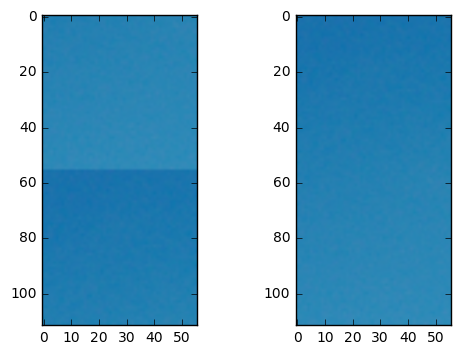

Wrong side : 123774
Correct side : 15924
-------
Ratio w/c: 7.7727957799547855


In [150]:
check_diss(0,1, 't', 'b')

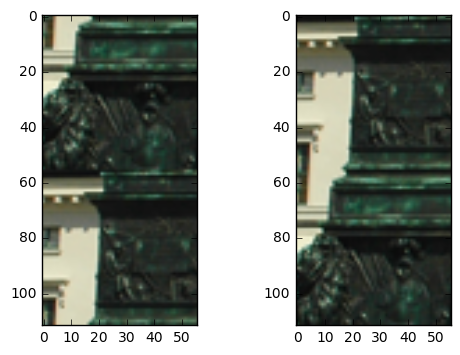

Wrong side : 188541
Correct side : 425606
-------
Ratio w/c: 0.4429942247054788


In [151]:
check_diss(13,14, 't','b')

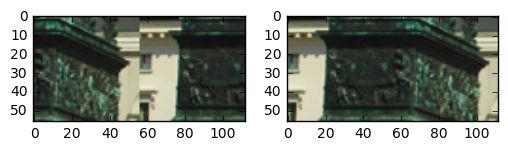

Wrong side : 847200
Correct side : 19357
-------
Ratio w/c: 43.76711267241825


In [152]:
check_diss(13,22,'l','r')

The results are of course imperfect (see second example), and improving this probability approximation could further improve the algorithm efficiency, but it is already better than with RGB values (higher contrast). We could maybe use a convolutional net (known to be effective on image understanding tasks) to predict the probability as a $[0,1]^4$ vector.

Even if it may be thrilling, for now, let's compute dissimilarity values for all ternaries (piece 1, piece 2, side) into a $D$ matrix.

In [153]:
def D_matrix(elems):
    n = len(elems)
    D = np.zeros((n,n,4), dtype=np.uint32)
    for i in range(n):
        for j in range(n):
            k = 0
            for side in ['t','b','l','r']:
                # top is 0, bottom is 1
                # left is 2, right is 3
                D[i,j,k] = dissimilarity(elems[i], elems[j], side)
                k += 1
    return D

In [154]:
D = D_matrix(new_pieces)

In [155]:
D.nbytes # way lighter than A

186624

Now, we want to normalize these dissimilarity measure into affinity values. We compute : $$A(p_i, p_j, s) = exp( -\frac{D(p_i,p_j,s)}{2 \delta_{i,s}^2} )$$
where $\delta_{i,s}$ is the square root of the difference between the two smallest $D(p_i, \cdot, s)$ values.

In [156]:
def get_deltas(D):
    deltas = np.zeros((D.shape[0],4))
    
    for i in range(D.shape[0]):
        for k in range(4):
            min1 = min2 = np.max(D)

            for j in range(D.shape[1]):
                if D[i,j,k] < min1:
                    min2 = min1
                    min1 = D[i,j,k]
                elif D[i,j,k] < min2 and D[i,j,k] != min1:
                    min2 = D[i,j,k]
        
            deltas[i,k] = np.sqrt(min2 - min1)
    
    return deltas

In [157]:
deltas = get_deltas(D)

In [158]:
def to_affinity(D, deltas):
    A = np.zeros(D.shape, dtype=np.float32)
    for i in range(D.shape[0]):
        for k in range(4):
            A[i,:,k] = np.exp(-0.5 * D[i,:,k] / deltas[i,k]**2)
            
            if np.sum(A[i,:,k]) != 0:
                A[i,:,k] /= np.sum(A[i,:,k])
            
    return A

In [159]:
A=to_affinity(D, deltas)

Just to check our values are correct :

In [160]:
np.max(A)

0.62245935

In [161]:
np.min(A)

0.0

In [162]:
np.sum(A[0,:,0])

1.0

In [163]:
print("Top-left corner - best matches")
print("top :", np.argmax(A[0,:,0])) #'top' no real best
print("bottom :", np.argmax(A[0,:,1])) #'bottom' best should be 1
print("left :", np.argmax(A[0,:,2])) #'left' no real best
print("right :", np.argmax(A[0,:,3])) #'right' best should be 9

Top-left corner - best matches
top : 90
bottom : 1
left : 90
right : 9


In [164]:
print("Piece number 12 - best matches")
print("top :", np.argmax(A[12,:,0])) #'top' best should be 11
print("bottom :", np.argmax(A[12,:,1])) #'bottom' best should be 13
print("left :", np.argmax(A[12,:,2])) #'left' should be 3
print("right :", np.argmax(A[12,:,3])) #'right' best should be 21

Piece number 12 - best matches
top : 11
bottom : 13
left : 38
right : 21


In [165]:
print("A(12, 38, left) =", A[12,38,2])
print("A(12, 3, left) =", A[12,3,2])

A(12, 38, left) = 0.129031
A(12, 3, left) = 0.0146876


Except for some errors, we see that most of the matches are correct.

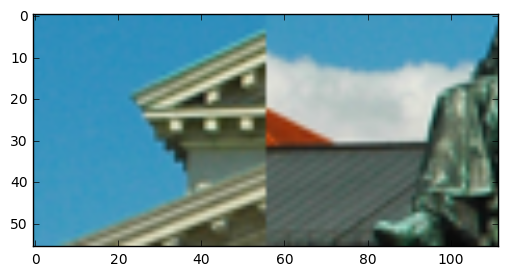

In [166]:
plt.imshow(assemble(pieces[12],pieces[38],'l'))

The above match seems to be coherent regarding textures along the edge, so we are not too disappointed.

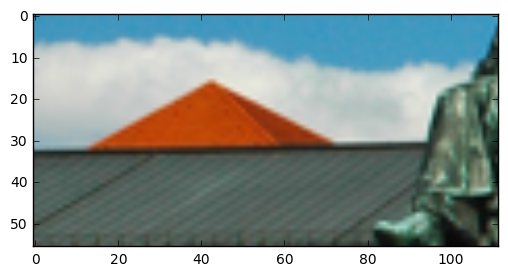

In [167]:
plt.imshow(assemble(pieces[12], pieces[3], 'l'))

## Particles and the SMC algorithm

We start by defining a particle class, then we will define the algorithm class to solve the puzzle (and later add timer functions and other descriptive statistics).

In [105]:
class Particle:
    def __init__(self, 
                 past = None, 
                 new = None, 
                 nl_dic = None, 
                 size = (9,12), 
                 A = None, gamma = 0.4, 
                 verbose = False):
        #if new particle
        #    Particle(size, A, gamma)
        #if follower
        #    Particle(past, new, nl_dic)
        #        nl_dic is used to store adjacent locations
        
        if past is None:
            self.state = 1
            self.weight = 1
            self.selected = [(0,0)] #first piece into top left corner
            self.rem_locs, self.rem_pieces = set(range(1,108)), set(range(1,108))
            self.size = size
            self.max_state = size[0] * size[1]
            self.A = A
            self.gamma = gamma
        else:
            from copy import copy
            # copy attributes
            self.weight = copy(past.weight)
            self.selected = copy(past.selected)
            self.rem_locs, self.rem_pieces = copy(past.rem_locs), copy(past.rem_pieces)
            self.nbh = copy(past.nbh)
            self.size = copy(past.size)
            self.max_state = self.size[0] * self.size[1]
            self.A = past.A
            self.gamma = copy(past.gamma)
            self.state = copy(past.state) + 1
            
            # update with new item
            if verbose: print('weight before reweight : {}'.format(self.weight))
            self.weight = self.reweight(new)
            if verbose: print('weight after reweight : {}'.format(self.weight))
            
            self.selected.append(new)
            if verbose: print('update selector : {}'.format(new))
            
            try:
                self.rem_locs.remove(new[1])
                self.rem_pieces.remove(new[0])
            except:
                print(self.selected)
                print(self.rem_pieces)
                raise
            
            # update neighborhood
            self.update_nbh(new, nl_dic)
    
    def get_neighborhood(self, nl_dic):
        #get all potential pairs (piece, location)
        nbh = []
        
        for v in self.selected:
            for loc in self.rem_locs.intersection(nl_dic[v[1]]):
                for piece in self.rem_pieces:
                    nbh.append((piece, loc))
        
        return set(nbh)
    
    def init_nbh(self, nl_dic):
        self.nbh = self.get_neighborhood(nl_dic)
    
    def update_nbh(self, new, nl_dic):
        self.nbh.remove(new)
        new_loc = new[1]
        new_piece = new[0]
        for i in self.rem_pieces:
            try:
                self.nbh.remove((i, new_loc))
            except:
                #print("couldnt remove {} from nbh".format((i, new_loc)))
                continue
        
        for j in self.rem_locs:
            try:
                self.nbh.remove((new_piece, j))
            except:
                continue
        
        for loc in self.rem_locs.intersection(nl_dic[new[1]]):
            for piece in self.rem_pieces:
                self.nbh.add((piece, loc))
        
    
    def reweight(self, new):
        #use new proposal to weight the particle
        to_check = self.near_locs(new[1])
        val = 0
        corr = { #0:top, 1:bottom, 2:left, 3:right
            1: 1, -1: 0,
            self.size[0]: 3, 
            - self.size[0]: 2
        }
        for loc in to_check:
            if loc in self.rem_locs:
                #still unexplored
                continue
            move = new[1] - loc
            side = corr[move]
            val += self.A[self.get_piece(loc), new[0], side]
                
        return self.weight * np.exp(2 * val / self.gamma)
    
    def near_locs(self, q):
        #compute all potential adjacent board locations
        moves = []
        nr = self.size[0]
        row, col = q%nr, q//nr
        
        if row == 0:
            moves += [1]
        elif row == nr - 1:
            moves += [-1]
        else:
            moves += [1,-1]
        
        if col == 0:
            moves += [nr]
        elif col == self.size[1] - 1:
            moves += [-nr]
        else:
            moves += [nr, -nr]
            
        return [q+m for m in moves]
    
    def move_to_side(self, move):
        corr = { #0:top, 1:bottom, 2:left, 3:right
            1: 1, -1: 0,
            self.size[0]: 3, 
            - self.size[0]: 2
        }
        return corr[move]
    
    def get_piece(self, loc):
        for v in self.selected:
            if v[1] == loc:
                return v[0]
        raise Exception('Location {} is not yet filled.'.format(loc))

In [109]:
class PuzzleSMC:
    def __init__(self, image_id, n_particles,
                 patch_size=56,
                 run=False):
        print('Initializing puzzle...')
        
        # load image and split into pieces (get grid shape too)
        print('\tLoading img {}'.format(image_id))
        self.pieces, self.shape = self.img_to_pieces(image_id, patch_size)
        
        # store affinities
        print('\t\tOK\n\tComputing graph edges weights...')
        self.A = self.get_aff(self.pieces)
        self.nl_dic = self.compute_near_locs()
        
        ## article multiplies this value by number of pieces
        ## we find this lowers weight values too much
        self.gamma = np.max(self.A) #* len(self.pieces)
        
        # init particles
        print('\t\tOK\n\tInitializing particles...')
        self.n_particles = n_particles
        
        ## Top left corner init
        first_part = Particle(
            A=self.A,
            gamma=self.gamma,
            size=self.shape
        )
        first_part.init_nbh(self.nl_dic)
        
        ## Store unique particles and define equiv classes
        self.particles = [first_part]
        self.sim_ix = [0 for k in range(self.n_particles)]
            
        # run loop
        if run:
            print('\t\tOK\n\n-- RUN --\n')
            self.result = self.run()
        
    def run(self):
        #last_weights = [0]
        
        for state in range(1, self.max_state):
            len_uniq = len(self.particles)
            weights = [part.weight for part in self.particles]
            avg_weight = np.mean(weights)
            
            if state%5 == 0 or len_uniq < self.n_particles:
                print('\tstate : {}/{}'.format(state, self.max_state))
                print('\t\tunique particles : {}'.format(len_uniq))
                print('\t\tavg particle weight : {}'.format(avg_weight))
                print('\t\tmax weight : {}'.format(np.max(weights)))
                
            try:
                temp = self.propose()
                weights = self.evaluate(temp)
                self.resample(temp, weights)
                #assert last_weights != weights
                #last_weights = weights
            except:
                print('state : ', state)
                print('min-max weight : ', np.min(weights), np.max(weights))
                print('n_unique : ', len(self.particles))
                print('n_followers : ', len(temp))
                raise
        
        self.result = self.get_best()
        return self.result
    
    def propose(self):
        temp = []
        
        for i in range(len(self.particles)):
            part = self.particles[i]
            fols = part.nbh
            for fol in fols:
                temp.append((i,fol))
                
        return temp
    
    def evaluate(self, temp):
        # normalize weights to sample from
        weights = []
        
        for i, fol in temp:
                
            w = self.particles[i].reweight(fol)
            
            #self.sim_ix.count(i) is the number of particles
            # in the equivalence class
            weights.append(w*self.sim_ix.count(i)) #testing without it
        
        return weights / np.sum(weights)
    
    def resample(self, temp, weights):
        # sample self.n_particles from weights
        # and update self.particles
        sampled_ix = np.random.choice(
            list(range(len(temp))), 
            size=self.n_particles,
            p=weights
        )
        
        rem_uniques = set(sampled_ix)
        unique_particles = []
        unique_ix, sim_ix = 0, []
        
        for ix in sampled_ix:
            if ix in rem_uniques:
                i, fol = temp[ix]
                past = self.particles[i]
                
                unique_particles.append(
                    Particle(
                        past = past,
                        new = fol,
                        nl_dic = self.nl_dic
                    )
                )
                unique_ix += 1
                rem_uniques.remove(ix)
            
            sim_ix.append(unique_ix)
        
        self.particles = unique_particles
        self.sim_ix = sim_ix
    
    def get_best(self):
        best = None
        
        for part in self.particles:
            if best is None:
                best = part
                continue
            if part.weight > best.weight:
                best = part
                
        return best
        
    def compute_near_locs(self):
        # to use only once and limit useless computations
        nl_dic = {}

        for q in range(self.max_state):
            nl_dic[q] = self.near_locs(q)
        
        return nl_dic
    
    def near_locs(self, q):
        #compute all potential adjacent board locations
        moves = []
        nr = self.shape[0]
        row, col = q%nr, q//nr
        
        if row == 0:
            moves += [1]
        elif row == nr - 1:
            moves += [-1]
        else:
            moves += [1,-1]
        
        if col == 0:
            moves += [nr]
        elif col == self.shape[1] - 1:
            moves += [-nr]
        else:
            moves += [nr, -nr]
            
        return [q+m for m in moves]
    
    def img_to_pieces(self, img_id, size):
        #we always give the first piece in the top left corner as a starter
        img_path = osp.join(IMG_PATH, '{}.png'.format(img_id))
        img = ndimage.imread(img_path)
        
        #matrix used for NTSC colour representation
        # in Matlab
        NTSC_mat = np.array([[0.299, 0.587, 0.114],
                             [0.596, -0.274, -0.322],
                             [0.211, -0.523, 0.312]])
        
        img_lab = np.zeros(img.shape, dtype=np.uint16)
        
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                img_lab[i,j,:] = NTSC_mat.dot(img[i,j,:])
                
        #required to equalize variance between channels
        img_lab[:,:,1] *= 7
        img_lab[:,:,2] *= 7
        
        pieces, p_lab = [], []
        vshape = img.shape[0]
        hshape = img.shape[1]

        if vshape%size != 0 or hshape%size != 0:
            msg = 'Problem with image shape ({}) and patch size ({})'.format(img.shape,size)
            raise Exception(msg)
            
        for hb in range(0,hshape,size):
            #b for begin, e for end
            he = hb + size
            for vb in range(0,vshape,size):
                ve = vb + size
                pieces.append(img[vb:ve, hb:he, :])
                p_lab.append(img_lab[vb:ve, hb:he, :])
        
        indexes = list(range(1,len(pieces)))
        np.random.shuffle(indexes)
        
        pieces = [pieces[ix] for ix in [0]+indexes]
        p_lab = [p_lab[ix] for ix in [0]+indexes]
        shape = (vshape//size, hshape//size)
        
        # we store the number of puzzle pieces
        self.max_state = len(pieces)
        
        # and the original rgb pieces too
        self.rgb_pieces = pieces
        
        return p_lab, shape
    
    def get_aff(self, pieces):
        try:
            D = self.D_matrix(pieces)
        except:
            print('len(pieces)')
            print(len(pieces))
            raise
            
        deltas = self.get_deltas(D)
        A = np.zeros(D.shape, dtype=np.float32)
        for i in range(D.shape[0]):
            for k in range(4):
                A[i,:,k] = np.exp( -0.5 * D[i,:,k] / deltas[i,k]**2 )
                
                if np.sum(A[i,:,k]) != 0:
                    A[i,:,k] = A[i,:,k] / np.sum(A[i,:,k])
        
        return A
        
    def dissimilarity(self, img1, img2, side):
        # we compute dissimilarity between
        # two puzzle pieces along the first one's `side`
        # side can be 't', 'b', 'l' or 'r'
        try:
            if side == 't':
                vec1, vec2 = img1[0, :], img2[-1, :]
            elif side == 'b':
                vec1, vec2 = img1[-1, :], img2[0, :]
            elif side == 'l':
                vec1, vec2 = img1[:, 0], img2[-1, :]
            elif side == 'r':
                vec1, vec2 = img1[:, -1], img2[:, 0]
            else:
                raise Exception('side can only be "t","b","r" or "l". "{}" was given.'.format(side))
        except:
            print(img2.shape)
            raise
                
        diffs = (vec1-vec2).astype(np.uint32) #was using uint8 for imgs, 
                                # but not large enough for squared vals
        return np.sum(np.square(diffs))
    
    def D_matrix(self, elems):
        n = len(elems)
        D = np.zeros((n,n,4), dtype=np.uint32)
        for i in range(n):
            for j in range(n):
                k = 0
                for side in ['t','b','l','r']:
                    try:
                        D[i,j,k] = self.dissimilarity(elems[i], elems[j], side)
                    except:
                        print(i)
                        plt.imshow(elems[i])
                        print(j)
                        print(elems[j])
                        raise
                    k += 1
        return D
    
    def get_deltas(self, D):
        deltas = np.zeros((D.shape[0],4))

        for i in range(D.shape[0]):
            for k in range(4):
                min1 = min2 = np.max(D)

                for j in range(D.shape[1]):
                    if D[i,j,k] < min1:
                        min2 = min1
                        min1 = D[i,j,k]
                    elif D[i,j,k] < min2 and D[i,j,k] != min1:
                        min2 = D[i,j,k]

                deltas[i,k] = np.sqrt(min2 - min1)

        return deltas

## How to use

The algorithm and its utility functions are stored in the `PuzzleSMC` class.

To define a puzzle, choose your `image_id` and the number of particles you want to be used in the PF.

In [171]:
puzzle = PuzzleSMC(image_id = 7,
                   n_particles = 200)

Initializing puzzle...
	Loading img 7
		OK
	Computing graph edges weights...
		OK
	Initializing particles...


Then simply `.run()` it :

In [175]:
from time import time
t = time()
puzzle.run()
print(time() - t)

	state : 1/108
		unique particles : 1
		avg particle weight : 1.0
		max weight : 1
	state : 2/108
		unique particles : 127
		avg particle weight : 1.0293325819644705
		max weight : 2.3493640920760814
	state : 3/108
		unique particles : 199
		avg particle weight : 1.0662134309892701
		max weight : 2.9170414995033718
	state : 5/108
		unique particles : 199
		avg particle weight : 1.413849771548584
		max weight : 3.7484358667480677
	state : 9/108
		unique particles : 198
		avg particle weight : 5.833001913126971
		max weight : 15.452958528573662
	state : 10/108
		unique particles : 200
		avg particle weight : 7.8805151845344446
		max weight : 26.98792329098321
	state : 11/108
		unique particles : 199
		avg particle weight : 10.041626651000959
		max weight : 65.90953713863159
	state : 15/108
		unique particles : 200
		avg particle weight : 73.60948160054618
		max weight : 250.02756089788326
	state : 20/108
		unique particles : 199
		avg particle weight : 278.196061544048
		max weight : 837

Let's show the initial order of pieces (we select all (i,i) vertices) :

In [176]:
pieces = puzzle.rgb_pieces
len(pieces)

108

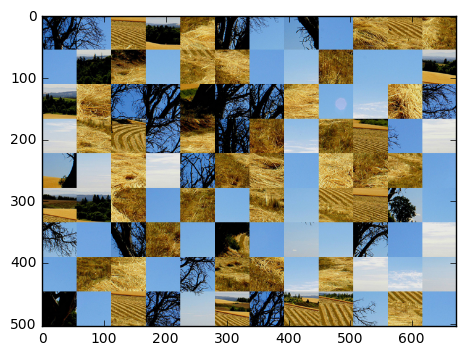

In [177]:
initial = assemble_pieces(pieces)
plt.imshow(initial)

Then the best Particle from the algorithm :

In [178]:
res = puzzle.result.selected

locations = [el[1] for el in res]
sorted_locix = np.argsort(locations)

sorted_pieces = []
for ix in sorted_locix:
    sorted_pieces.append(pieces[res[ix][0]])

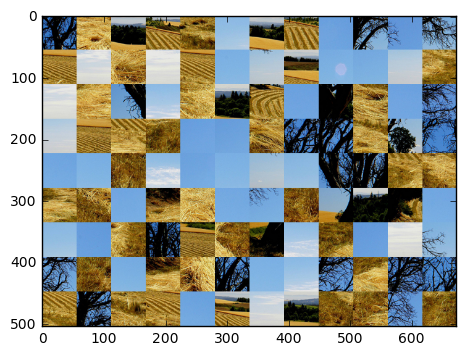

In [179]:
sorted_pic = assemble_pieces(sorted_pieces)
plt.imshow(sorted_pic)

***

To see sequentially the particle's trajectory, we defined an iterator object.

In [116]:
def show_part_state(pieces, state):
    full_pic = np.zeros((504, 672, 3), dtype=np.uint8)
    size = 56
    
    for p, q in state:
        h_ix = (q//9) * size
        v_ix = (q%9) * size

        full_pic[v_ix:v_ix+size, h_ix:h_ix+size, :] = pieces[p]
    
    return full_pic

In [117]:
def iter_part(pieces, selected):
    for i in range(len(selected)):
        pic = show_part_state(pieces, selected[:i])
        plt.imshow(pic)
        yield(i)

To use it, get the puzzle pieces from **`puzzle.rgb_pieces`** and the selection from the best particle **`puzzle.result.selected`**, and run :

In [118]:
#pieces = puzzle.rgb_pieces
#res = puzzle.result.selected
a = iter_part(pieces, res)

15

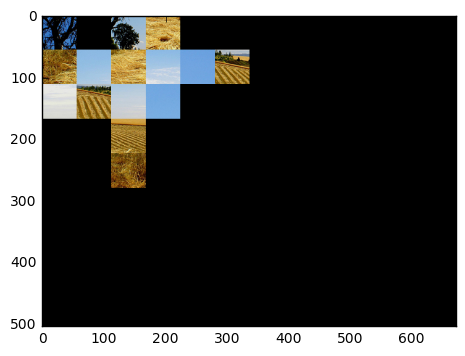

In [134]:
next(a)

## Results

You can see some of the algorithm results below. Number of particles used is in the pickle save filename (e.g. for image 1 and 1000 particles `"puzzle_img1_1000"`).

Aggregated results over the 20 provided images, using the 3 metrics (direct, cluster and neighbour comparisons) proposed in the article, are still lacking due to **obviously bad quality of predictions**.

In overall, we can see the algorithm is able to form series of correct particle followers, but suffers from random picks initializing a new series in a random place. We may assume the importance weighing mechanism is not selective enough to maintain good particles through the filter.

## Image 1

In [508]:
puzzle = pickle.load(open('puzzle_img1_1000', 'rb'))

res = puzzle.result.selected
pieces = puzzle.rgb_pieces

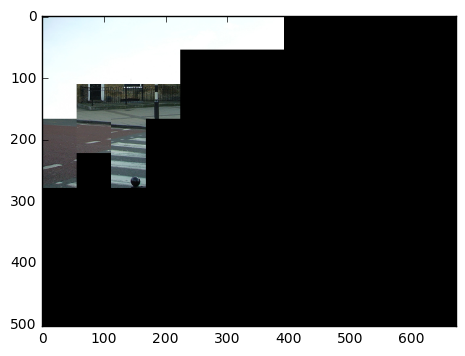

In [536]:
plt.imshow(show_part_state(pieces, res[:20]))

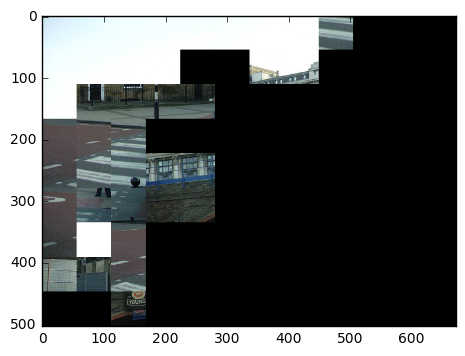

In [537]:
plt.imshow(show_part_state(pieces, res[:40]))

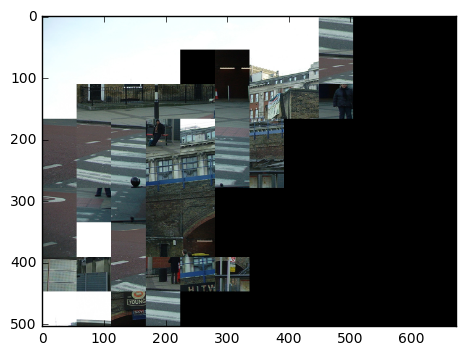

In [538]:
plt.imshow(show_part_state(pieces, res[:60]))

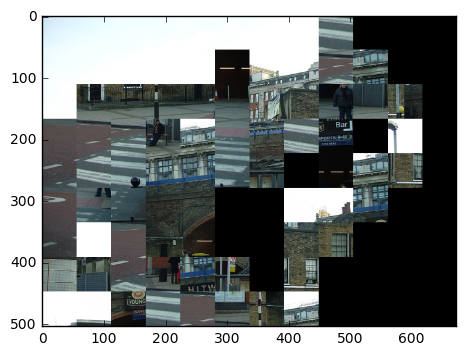

In [539]:
plt.imshow(show_part_state(pieces, res[:80]))

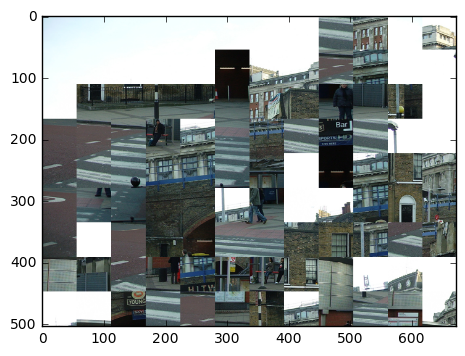

In [540]:
plt.imshow(show_part_state(pieces, res))

## Image 2

In [541]:
puzzle = pickle.load(open('puzzle_img2_1000', 'rb'))

res = puzzle.result.selected
pieces = puzzle.rgb_pieces

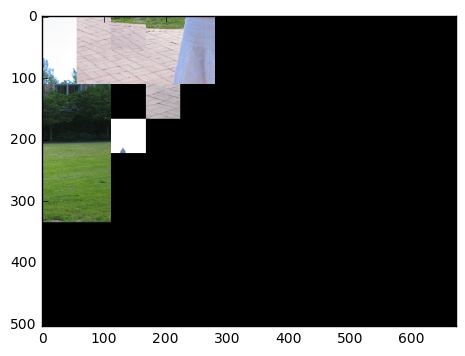

In [542]:
plt.imshow(show_part_state(pieces, res[:20]))

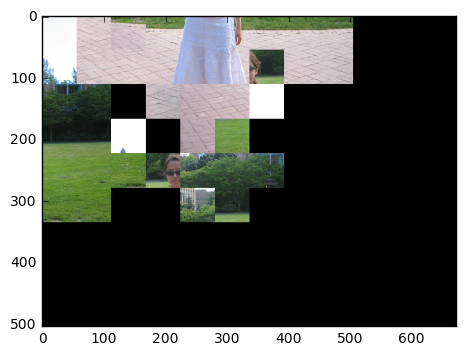

In [543]:
plt.imshow(show_part_state(pieces, res[:40]))

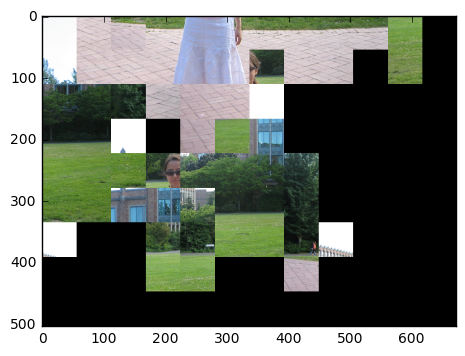

In [544]:
plt.imshow(show_part_state(pieces, res[:60]))

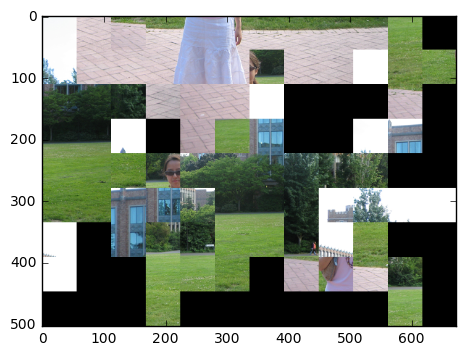

In [545]:
plt.imshow(show_part_state(pieces, res[:80]))

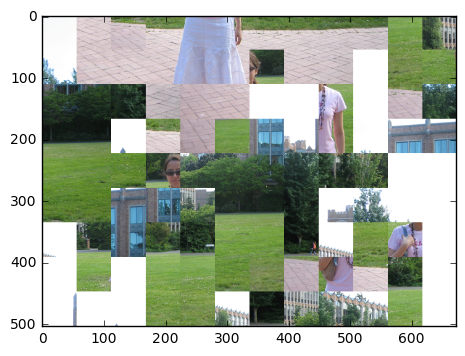

In [546]:
plt.imshow(show_part_state(pieces, res))

## Image 3

In [547]:
puzzle = pickle.load(open('puzzle_img3_1000', 'rb'))

res = puzzle.result.selected
pieces = puzzle.rgb_pieces

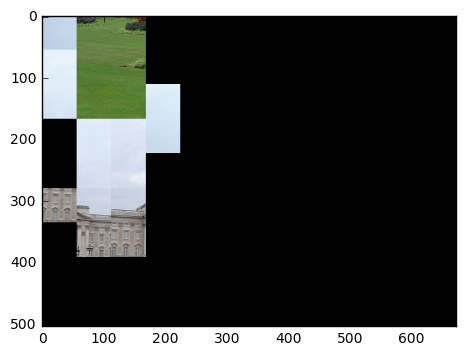

In [548]:
plt.imshow(show_part_state(pieces, res[:20]))

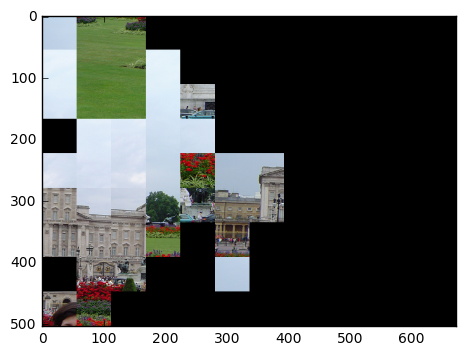

In [549]:
plt.imshow(show_part_state(pieces, res[:40]))

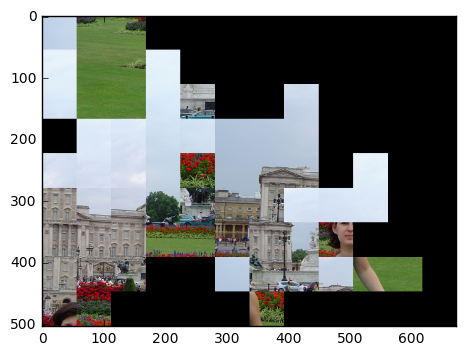

In [550]:
plt.imshow(show_part_state(pieces, res[:60]))

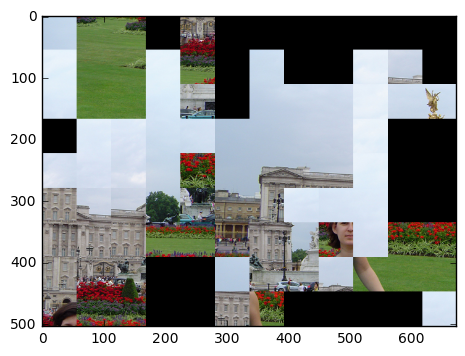

In [551]:
plt.imshow(show_part_state(pieces, res[:80]))

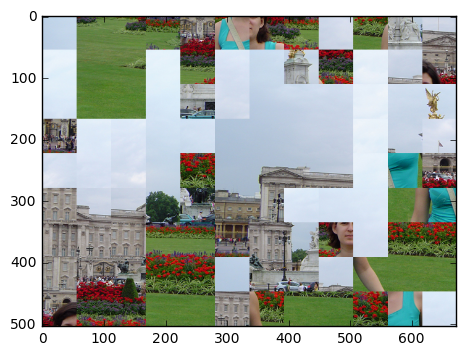

In [552]:
plt.imshow(show_part_state(pieces, res))

## Image 4
1500 particules

In [190]:
puzzle = pickle.load(open('puzzle_img4_1500', 'rb'))

res = puzzle.result.selected
pieces = puzzle.rgb_pieces

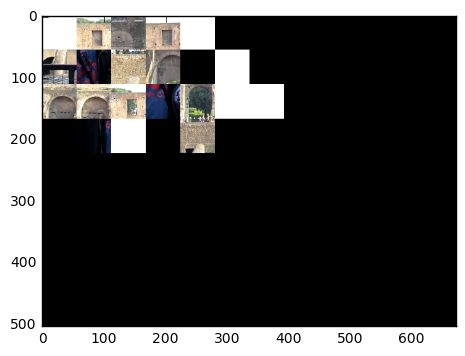

In [191]:
plt.imshow(show_part_state(pieces, res[:20]))

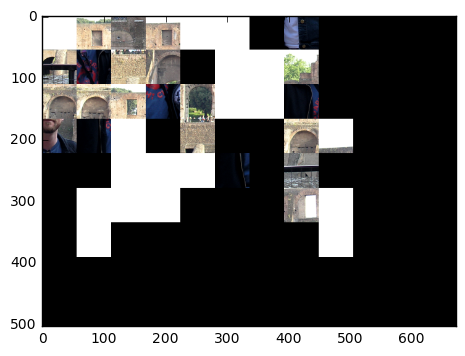

In [192]:
plt.imshow(show_part_state(pieces, res[:40]))

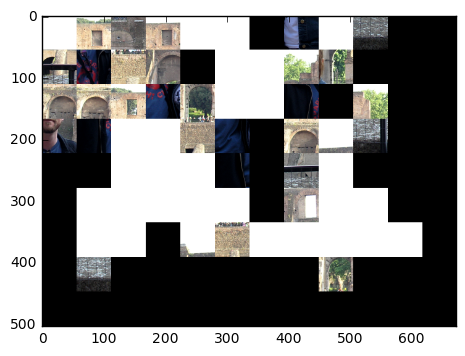

In [193]:
plt.imshow(show_part_state(pieces, res[:60]))

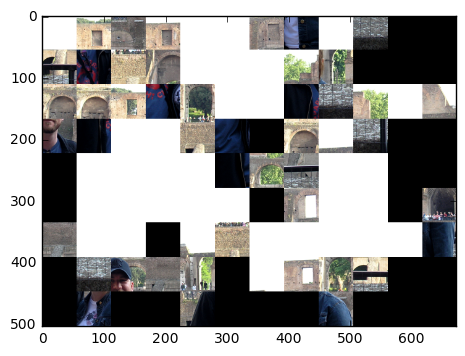

In [194]:
plt.imshow(show_part_state(pieces, res[:80]))

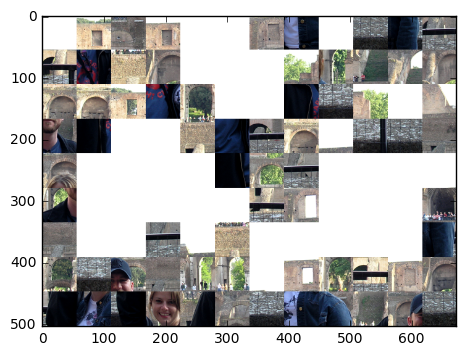

In [195]:
plt.imshow(show_part_state(pieces, res))

## Image 7

1000 particules

In [554]:
puzzle = pickle.load(open('puzzle_img7_1000', 'rb'))

res = puzzle.result.selected
pieces = puzzle.rgb_pieces

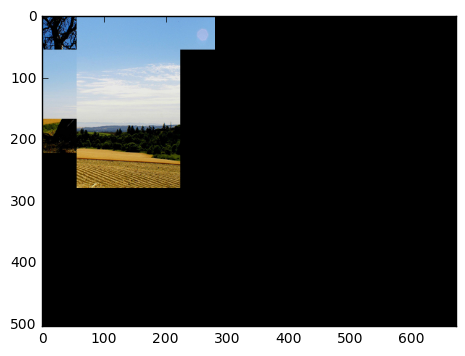

In [555]:
plt.imshow(show_part_state(pieces, res[:20]))

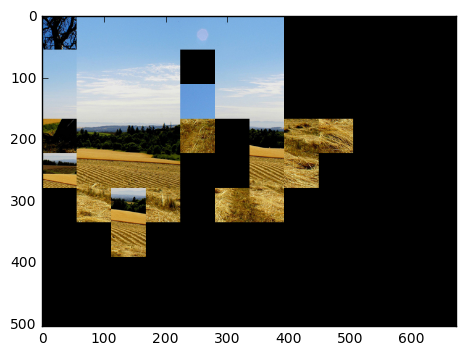

In [556]:
plt.imshow(show_part_state(pieces, res[:40]))

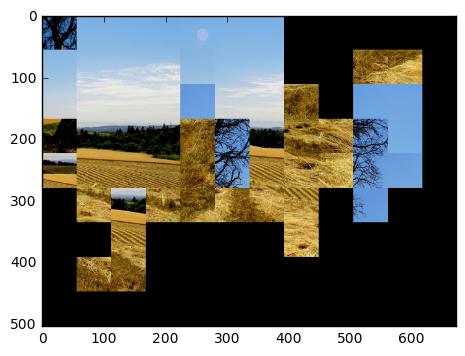

In [557]:
plt.imshow(show_part_state(pieces, res[:60]))

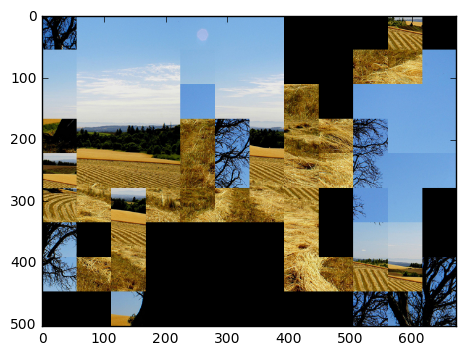

In [558]:
plt.imshow(show_part_state(pieces, res[:80]))

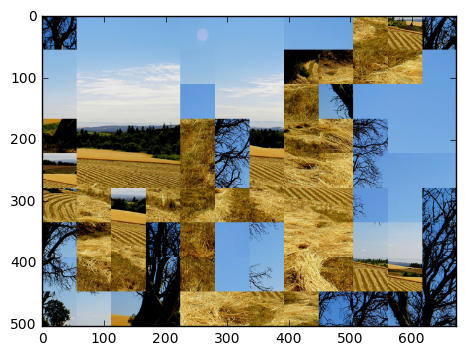

In [559]:
plt.imshow(show_part_state(pieces, res))

## Annex : Optimizing the solver

In order to reduce computation time, we want to introduce two ideas :

1. There may be **identical** particles at time step **t**
2. We can normalize the weights to sample from the obtained **equivalence classes**

For example, if we store the "fake" particles as a list of indexes pointing to a set of unique particles, at the first step we have :

+ `unique_particles = [ Particle( (0,0) ) ]`
+ `sim_ix = [ 0 for k in range(n_particles) ]`

This way we can keep the advantages of the Particle class without overflowing the memory. To update these lists at each time step, we need to formalize the substeps :

+ **Propose**
    + for each unique particle **i**, we get its followers **(fol)**
    + into a big global list : `[ (i, fol), ... ]`

+ **Evaluate**
    + for each couple `(i, fol)`, get its weight (without generating another Particle object)
    + to normalize the weights, we simply multiply each by the number of particles in the equivalence class **i**, then divide by their total sum

+ **Resample**
    + sample `n_particles` couples `(i, fol)` according to their normalized weights
    + generate the unique particles and the similarity index after the sampling
    
From this adaptation, particles are **identical** if they have the exact same history (even if they select the same vertices, the path may be different). We could have tried to aggregate over all the paths leading to a selection.